# 3D cell tracking with Ultrack

This document shows how Ultrack can  track cells in large fluorescence microscopy data. We use the zebrafish tail data from [zebrahub](https://zebrahub.ds.czbiohub.org/) acquired with [DaXi](https://www.nature.com/articles/s41592-022-01417-2).

Here, we use the image processing functions provided with Ultrack, but any other segmentation method could be used.
For example, refer to the [stardist_2 example](https://github.com/royerlab/ultrack/blob/main/examples/stardist_2d/2d_tracking.ipynb) to see how to use Ultrack with segmentation labels.

Note: This is not the same methodology used in the [zebrahub paper](https://www.biorxiv.org/content/10.1101/2023.03.06.531398v1). There, we used a convolutional neural network to predict the nuclei boundaries and the initial version of Ultrack software.

First, we import the required packages. You can install them using the conda environment file on this folder.

In [1]:
import napari
import numpy as np
import dask.array as da
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint

from ultrack import MainConfig, load_config, track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import robust_invert, detect_foreground
from ultrack.utils.array import array_apply, create_zarr

We open the data remotely using the `napari-ome-zarr` plugin.

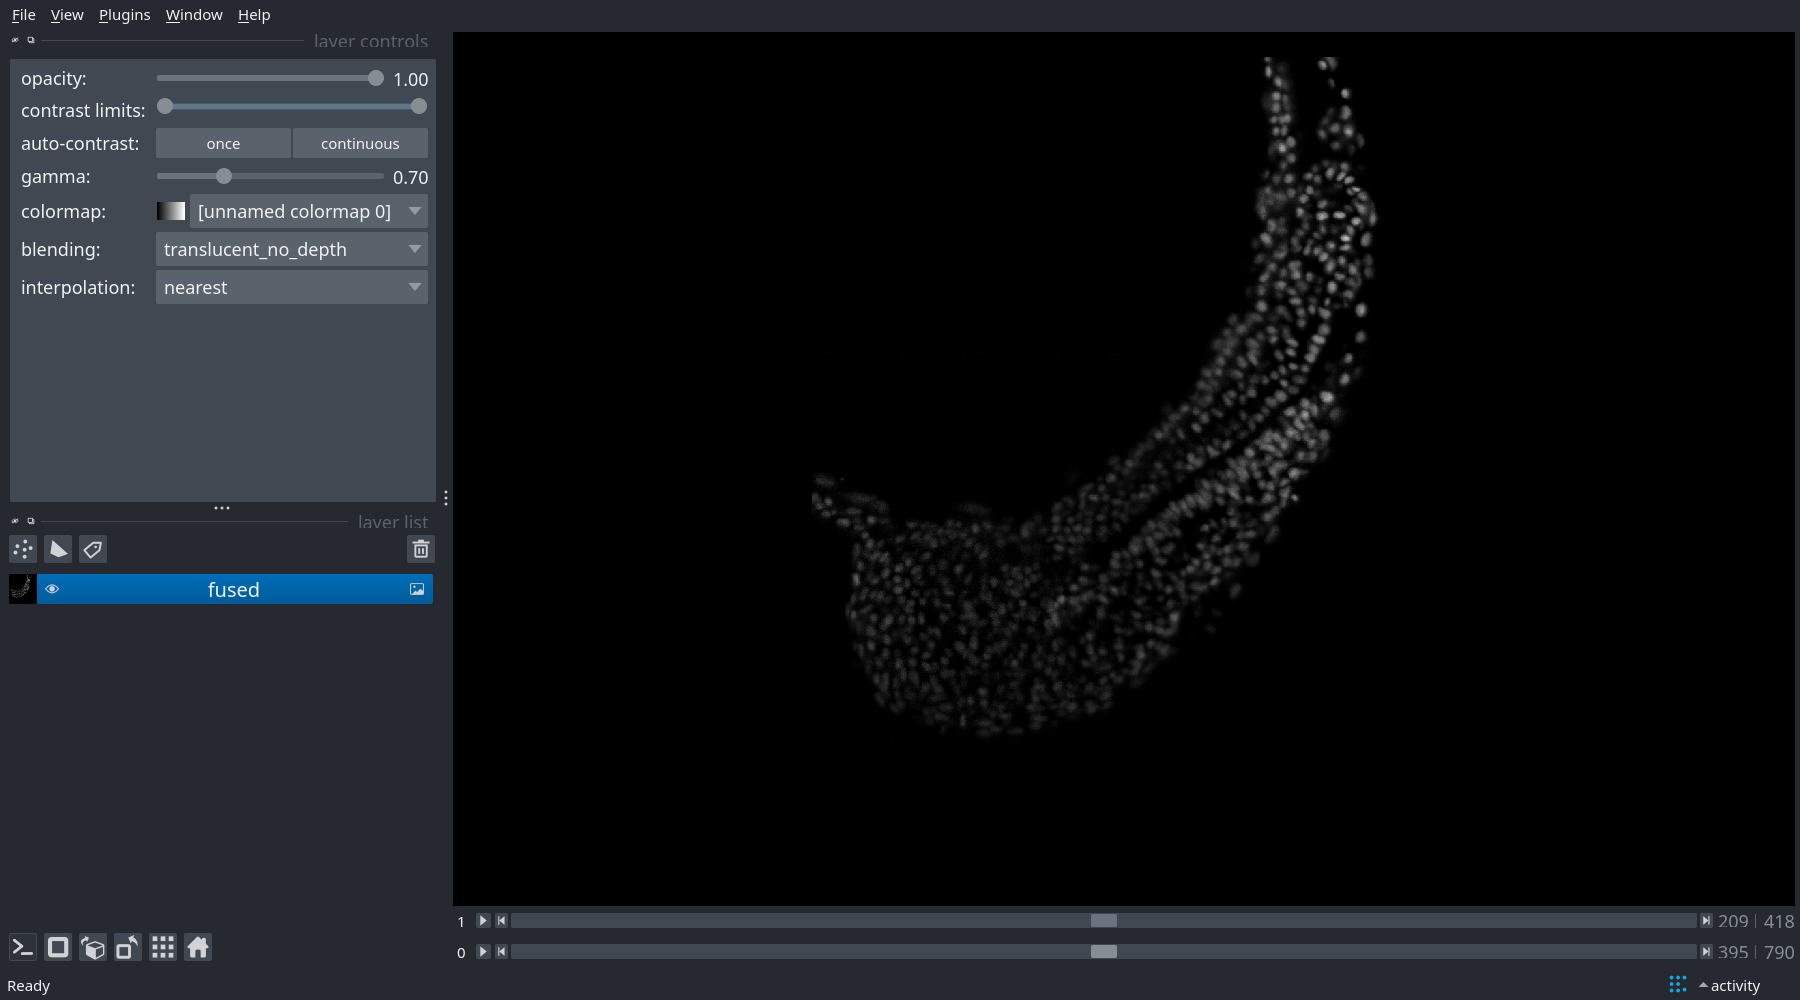

In [2]:
viewer = napari.Viewer()
viewer.window.resize(1800, 1000)

im_layer, = viewer.open(
    "http://public.czbiohub.org/royerlab/zebrahub/imaging/single-objective/ZSNS001_tail.ome.zarr/",
    plugin="napari-ome-zarr",
    rendering="attenuated_mip",
    gamma=0.7,
    contrast_limits=(0, 500),
)

nbscreenshot(viewer)

We setup to process only a subset of frames from the dataset, feel free to change the values below.

In [3]:
voxel_size = im_layer.scale[1:]  # (z, y, x) pixel size
start_idx = 400  # starting frame
viewer.dims.set_point(0, start_idx + 5)

image = im_layer.data[0]
image = image[start_idx:(start_idx + 10)]  # processing only a subset of time points
image.shape

(10, 420, 1217, 1091)

We detect which pixels contains cells and which are background using the `array_apply` function to apply the `detect_foreground` to each individual time point while saving it to the `detection.zarr` path.

Applying detect_foreground ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.90s/it]


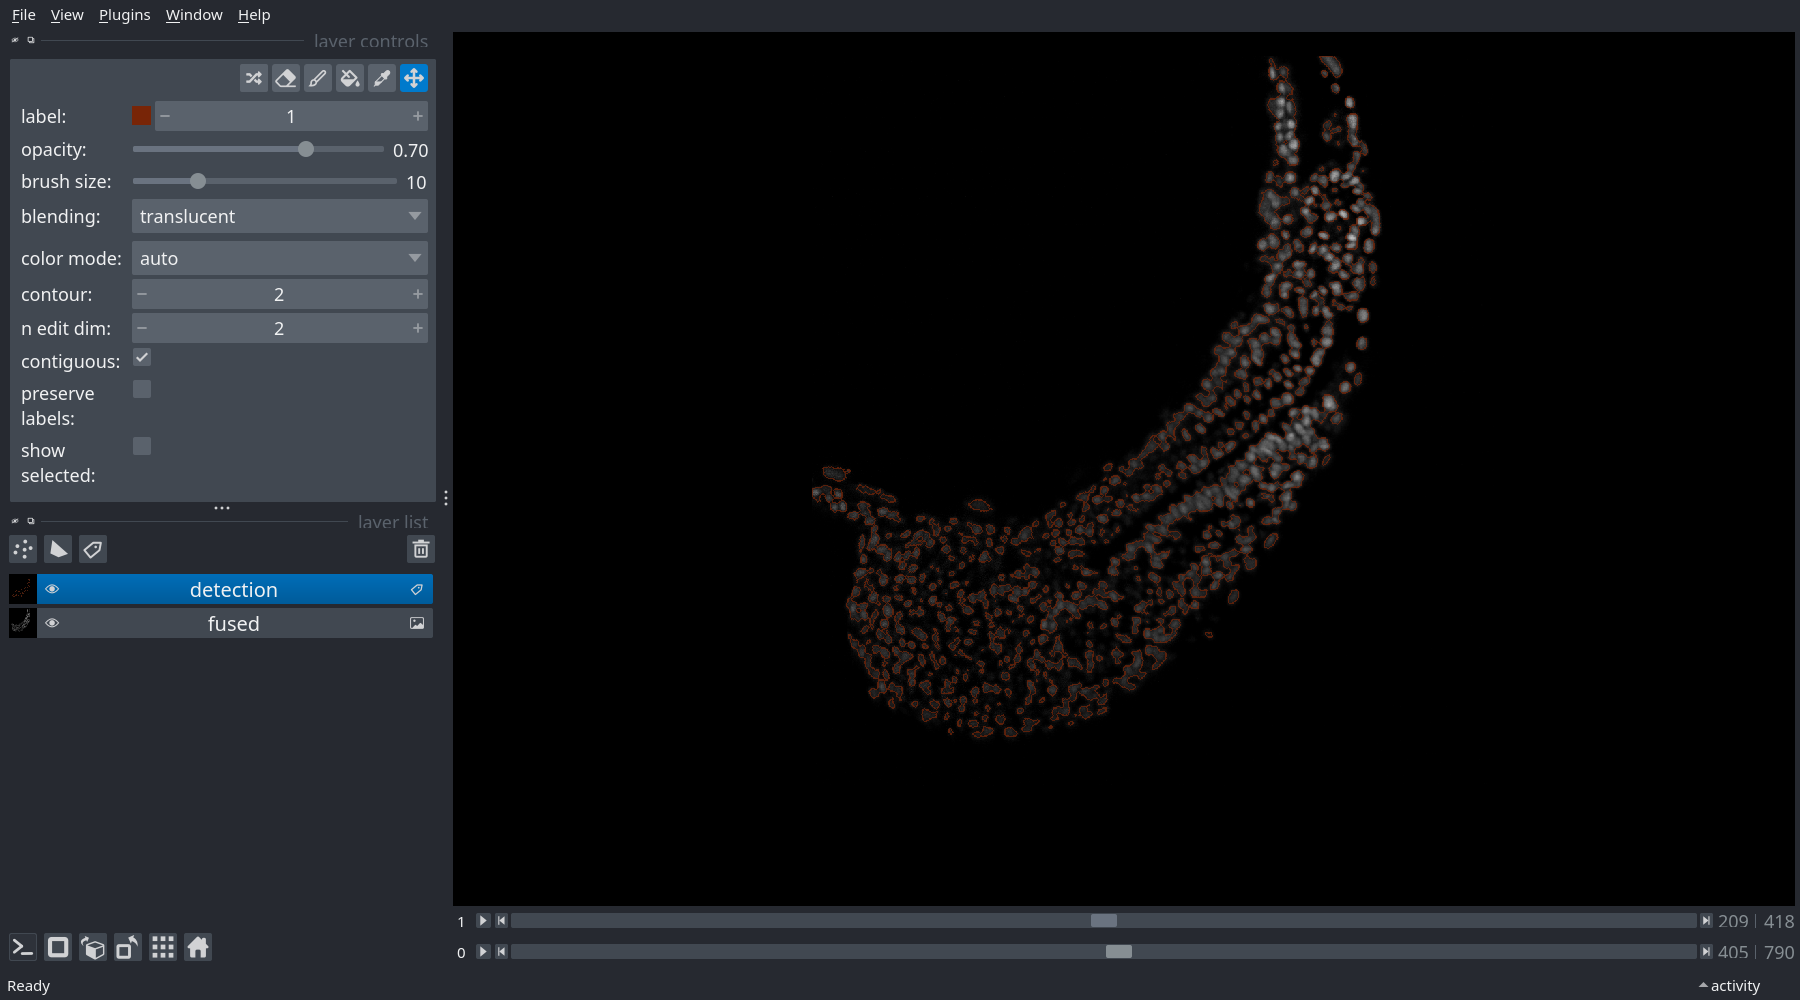

In [4]:
detection = create_zarr(image.shape, bool, store_or_path="detection.zarr", overwrite=True)
array_apply(
    image,
    out_array=detection,
    func=detect_foreground,
    sigma=25.0,
    voxel_size=voxel_size,
)

viewer.add_labels(
    detection,
    visible=True,
    translate=(start_idx, 0, 0, 0),
    scale=voxel_size,
).contour = 2

nbscreenshot(viewer)

Ultrack requires an estimate of the cell boundaries, we approximate this by inverting the image using the `robust_invert` function and saving it to `boundaries.zarr`.

In [5]:
boundaries = create_zarr(image.shape, np.float16, store_or_path="boundaries.zarr", overwrite=True)
array_apply(
    image,
    out_array=boundaries,
    func=robust_invert,
    voxel_size=voxel_size,
)

viewer.add_image(boundaries, visible=False, translate=(start_idx, 0, 0, 0), scale=voxel_size)

Applying robust_invert ...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.61s/it]


<Image layer 'boundaries' at 0x7f3f8bdf54e0>

Now we start the tracking stage. Ultrack parameters are provided in a configuration file which is equivalent to the `MainConfig` object.

Using a configuration file helps reproducing previous runs and it can be easily shared when using distributed processing.

In this example the configuration is already configured so we only need to load it. We change the segmentation threshold parameter as an example.

The configuration documentation can be found [here](https://github.com/royerlab/ultrack/tree/main/ultrack/config).

In [6]:
cfg = load_config("config.toml")
# cfg =  MainConfig()  # or load default config
cfg.segmentation_config.threshold = 0.5
pprint(cfg)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=500,
│   │   max_area=10000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f404268c670>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=5.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.002,
│   │   disappear_weight=-0.01,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=100,
│   │   overlap_size=5,
│   │   solution_gap=0.0,
│   │   time_limit=120000,
│   │   method=0,
│   │   n_threads=0,
│   │   link_function='power',
│   │   power=4.0,
│   │   bias=0.0
│   )
)

Once the configuration is set, it can be used with the cell detection and boundaries to compute the tracks.

In [7]:
track(
    cfg,
    detection=detection,
    edges=boundaries,
    scale=voxel_size,
    overwrite=True,
)

Linking nodes.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.34s/it]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 694321 rows, 901725 columns and 2153390 nonzeros
Model fingerprint: 0xc491f3a0
Variable types: 0 continuous, 901725 integer (901725 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-16, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 348598 rows and 358070 columns (presolve time = 8s) ...
Presolve removed 348598 rows and 358070 columns
Presolve time: 7.91s
Presolved: 345723 rows, 543655 columns, 1274833 nonzeros
Found heuristic solution: objective 5043.3524392
Variable types: 0 continuous, 543655 integer (543655 binary)

Concurrent LP optimizer: primal simplex, dua

Finally, we export the resulting tracks into the napari tracks format and a zarr with the instance segmentation masks.

Exporting segmentation masks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


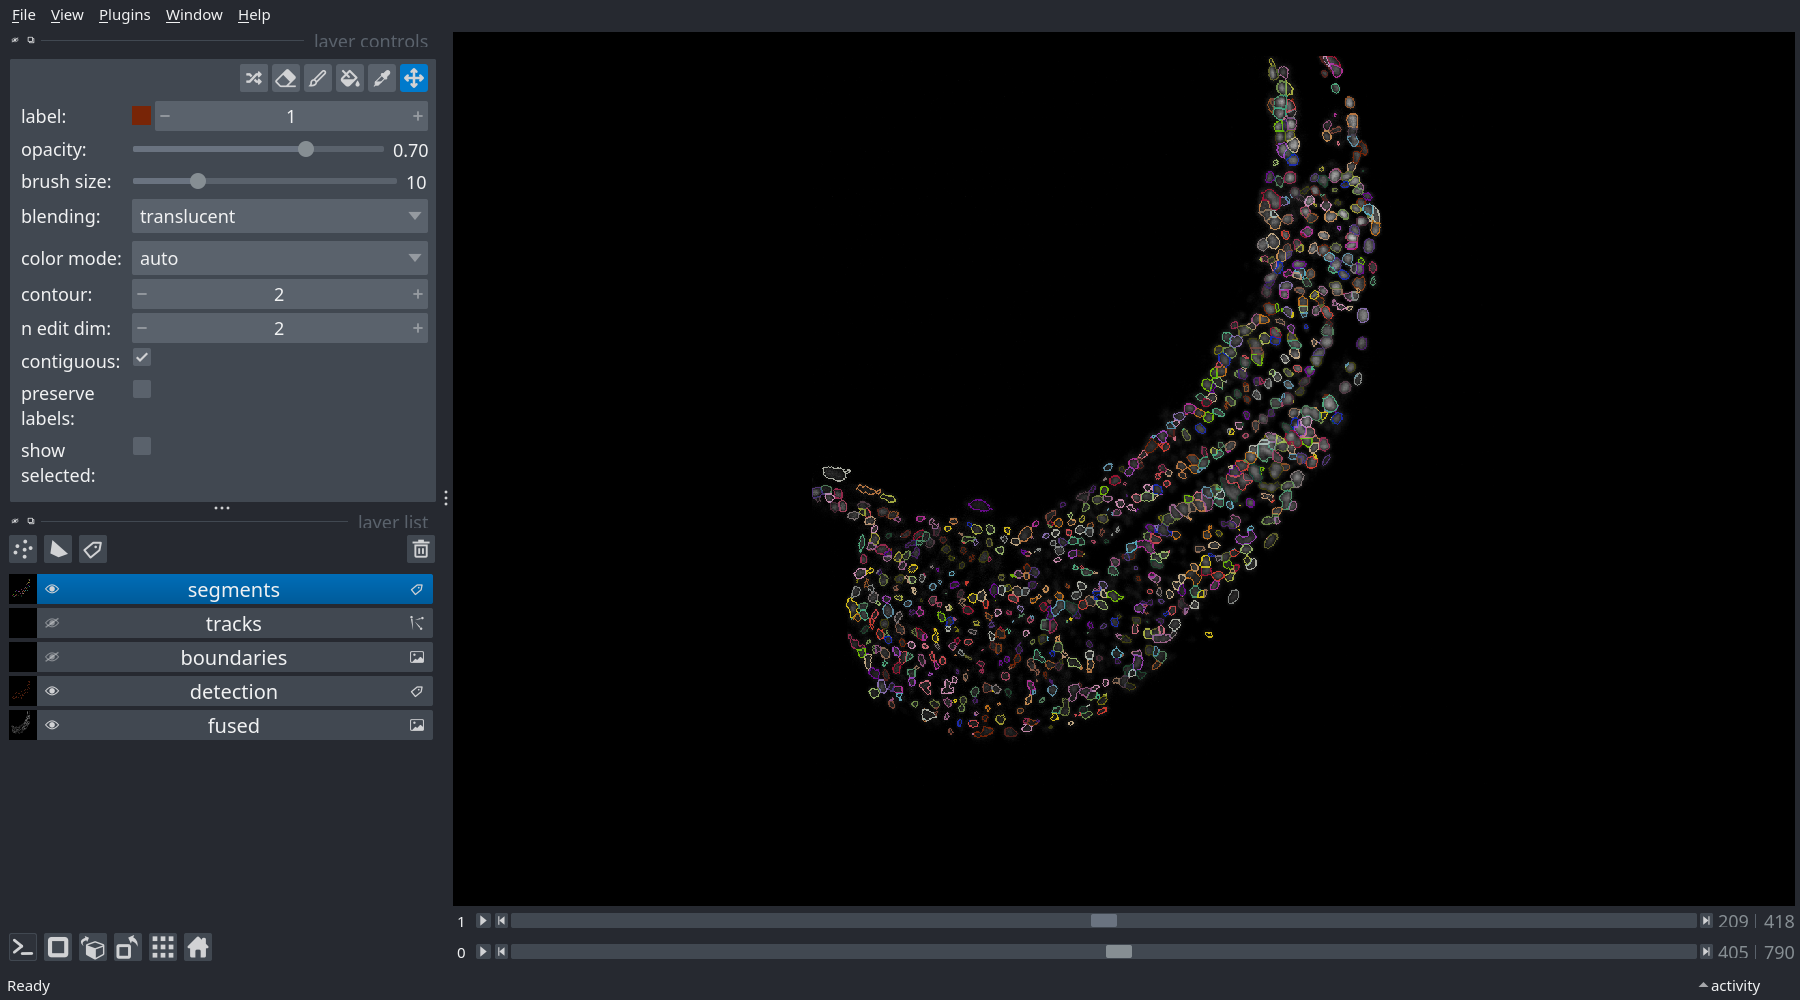

In [8]:
tracks_df, graph = to_tracks_layer(cfg)
tracks_df.to_csv("tracks.csv", index=False)

segments = tracks_to_zarr(
    cfg,
    tracks_df,
    store_or_path="segments.zarr",
    overwrite=True,
)

viewer.add_tracks(
    tracks_df[["track_id", "t", "z", "y", "x"]],
    name="tracks",
    graph=graph,
    scale=voxel_size,
    translate=(start_idx, 0, 0, 0),
    visible=False,
)

viewer.add_labels(
    da.from_zarr(segments),
    name="segments",
    scale=voxel_size,
    translate=(start_idx, 0, 0, 0),
).contour = 2

nbscreenshot(viewer)